# Введение в искусственные нейронные сети

# Урок 4. Сверточные нейронные сети

# <font color='blue'>Практическое задание</font>

Вариант 1. (простой)

- обучить сверточную нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг  (conv-pool)-(conv-pool)-...) на датасете fashion-mnist или cifar10
- оценить рост точности при увеличении ширины сети (больше ядер)
- оценить рост точности при увеличении глубины сети (больше слоев)
- (опциционально)сравнить с точностью полносвязной сети для этой выборки
    </li>

Вариант 2. (сложный)
- реализовать нейронную сеть или стек из сверток (Concatenate) на сifar10.
- оценить рост точности при увеличении ширины сети (больше ядер), больше нитей.
- оценить рост точности при увеличении глубины сети (больше слоев)
    </li>
</ol>

Выполнил __Соковнин И.Л.__

# Сеть AlexNet 

In [1]:
# import cv2  # OpenCV

In [2]:
# from tensorflow.keras.utils import plot_model 

In [3]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras # расскоментируйте эту строку, чтобы начать обучение


from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, Input  # Convolution (сверточный) слой
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization  
# Pooling слои

import os

In [4]:
# from tensorflow.keras.datasets import fashion_mnist
# from tensorflow.keras.utils import to_categorical

In [5]:
# class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# class_names = ['Футболка/топ', 'Брюки', 'Свитер', 'Платье', 'Плащь', 'Сандали', 'Рубашка', 'Кросовки', 'Сумки', 'Ботинки']

In [6]:
# Цветной датасет 10 классов, картинки 32x32 с цветными изображениями
# Есть cifar100 - 100 классов
from tensorflow.keras.datasets import cifar10

In [7]:
# установка параметров нейросети
batch_size = 32
num_classes = 10
epochs = 10
data_augmentation = False
num_predictions = 20
model_name = 'keras_cifar10_trained_model.h5'

In [8]:
# FeaturesDict({
#     'id': Text(shape=(), dtype=tf.string),
#     'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
#     'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
# })

In [9]:
# Название классов из набора cifar10
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

In [10]:
# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

170508288/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


In [11]:
np.argmax(y_train[0]), classes[int(np.argmax(y_train[0]))], y_train[0]

(6, 'лягушка', array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32))

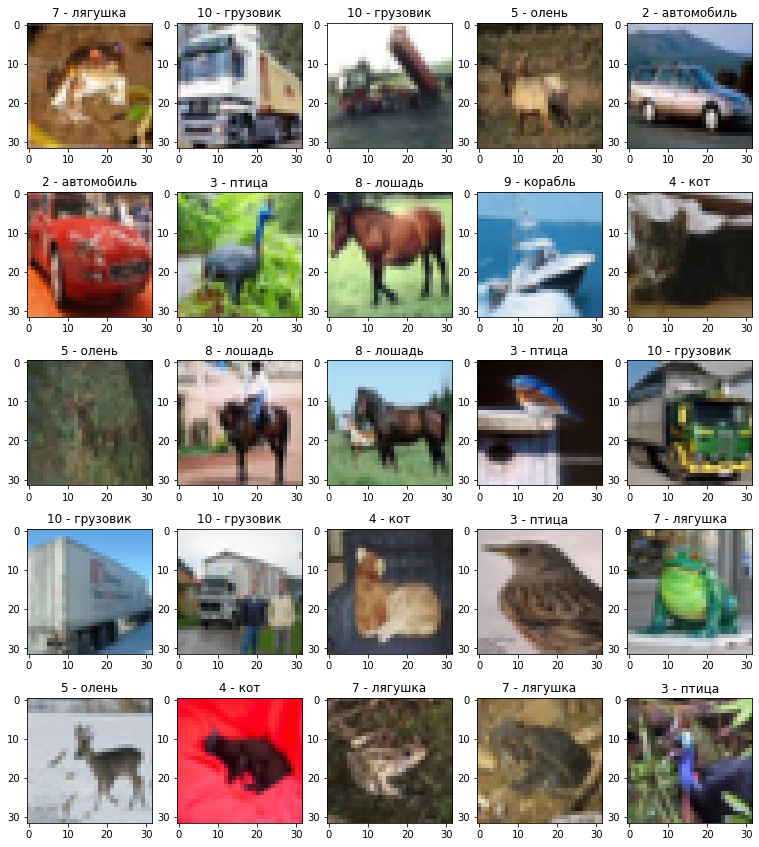

In [12]:
# First 25 images in the train dataset
plt.figure(figsize = (13, 15))
for i in range(25):
    image = x_train[i,:,:]
    image = np.array(image)
    plt.subplot(5, 5, i+1)
    # plt.title(str(y_train[i]) + ' - ' + classes[int(y_train[i])])
    plt.title(str(np.argmax(y_train[i])+1) + ' - ' + classes[np.argmax(y_train[i])])
    plt.imshow(image)
    # plt.axis('off')
plt.show() 

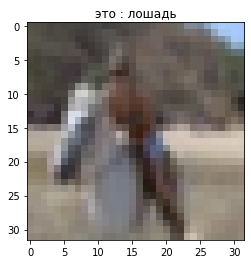

In [13]:
N = 9013
# N = 913

plt.imshow(x_test[N][:,:,:])
plt.title('это : ' + classes[np.argmax(y_test[N,:])])
plt.show()

# Сеть AlexNet 


1:56:00

![alexnet.jpg](alexnet.jpg)

- Convolution - свертка
- Subsampling - Подвыборка
- Full connection - Полное подключение?
- Gaussian connecttings - Гауссовы соединения?
- Overlapping - перекрытие
- dropout - выбывать
- max-pooling

In [14]:
# установка параметров нейросети
# batch_size = 1024
batch_size = 32
num_classes = 10
epochs = 10
data_augmentation = False
num_predictions = 20
model_name = 'keras_cifar10_trained_model.h5'

###### Базовая модель ( по аналогии как из 4 лекции)

 # Базовая модель

In [18]:
# конфигурирование слоев нейросети
model = Sequential([
                    
    # слои нейросети отвественные за свертку и max-pooling
    Conv2D(filters=32,  # количество фильтров - эквивалентно кол-ву нейронов (ширина слоя)!!!
        kernel_size=(11, 11),  # кортеж, размер ядра фильтра (размер фильтра по осям, апертура фильтра)
        strides=(1, 1),   # шаг применения фильтра к пикселам (пропуск пикселов) - вместо пулинга
        input_shape=x_train.shape[1:],
        activation='relu',  # активация
        padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    Dropout( 0.25),

    Conv2D(filters=32,  # количество фильтров - эквивалентно кол-ву нейронов (ширина слоя)!!!
        kernel_size=(8, 8),  # кортеж размер ядра фильтра (размер фильтра по осям, апертура фильтра)
        strides=(1, 1),   # шаг применения фильтра к пикселам (пропуск пикселов) - вместо пулинга
        input_shape=x_train.shape[1:],
        activation='relu'  # активация
      ),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    Dropout( 0.25),
    
    Conv2D(filters=32, kernel_size=(5, 5), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2, 2)),
    Dropout( 0.25),

    # Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu'),
    # BatchNormalization(),
    # MaxPooling2D(pool_size=(3,3), strides=(2, 2)),
    # Dropout(0.25),
    
    # Из конволютивного слоя нельзя передать информацию в плотный слой без векторизации
    # поэтому используем layers.Flatten() чтоб не делать reshape, сглаживание CNN выхода,
    # чтобы можно было его присоединить к полносвязногому слою.

    # полносвязные слои нейронной сети
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax'),
])

# инициализация RMSprop optimizer
#opt = tensorflow.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        11648     
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          65568     
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 32)         1

In [19]:
w_old = model.layers[-1].get_weights()
# Ядро 3x3
w_old[0].shape  # смотрим на одно ядро размер 3x3, 1 слой на входе, 1-но ядро на выходе
# (3, 3, 1, 1)


(512, 10)

In [20]:
  summary_data = pd.DataFrame(columns=['layers', 'neurons', 'loss', 'accuracy', 'val_loss', 'val_accuracy'])

  print('Не используется data augmentation')
  hist = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_test, y_test),
            shuffle=True)

Не используется data augmentation
Epoch 1/10
1563/1563 [==============================] - 242s 154ms/step - loss: 1.9065 - accuracy: 0.2863 - val_loss: 2.5375 - val_accuracy: 0.2359
Epoch 2/10
1563/1563 [==============================] - 244s 156ms/step - loss: 1.6254 - accuracy: 0.4002 - val_loss: 1.4662 - val_accuracy: 0.4702
Epoch 3/10
1563/1563 [==============================] - 240s 154ms/step - loss: 1.5163 - accuracy: 0.4450 - val_loss: 2.0352 - val_accuracy: 0.2788
Epoch 4/10
1563/1563 [==============================] - 241s 154ms/step - loss: 1.4388 - accuracy: 0.4759 - val_loss: 1.3942 - val_accuracy: 0.4768
Epoch 5/10
1563/1563 [==============================] - 240s 154ms/step - loss: 1.3842 - accuracy: 0.4997 - val_loss: 1.5256 - val_accuracy: 0.4782
Epoch 6/10
1563/1563 [==============================] - 240s 154ms/step - loss: 1.3302 - accuracy: 0.5216 - val_loss: 1.2978 - val_accuracy: 0.5382
Epoch 7/10
1563/1563 [==============================] - 240s 153ms/step - loss

In [21]:
# model evaluation for training set
loss_metric_train = model.evaluate(x_train, y_train)

# проверка работы обученной модели
loss_metric_test = model.evaluate(x_test, y_test, verbose=1)

print('Test loss:', loss_metric_test[0])
print('Test accuracy:', loss_metric_test[1])

summary_data.loc["Базовая модель", ['layers', 'neurons', 'loss', 'accuracy', 'val_loss', 'val_accuracy']] = [ 3,  32, loss_metric_train[0], loss_metric_train[1], loss_metric_test[0], loss_metric_test[1]]
summary_data

313/313 [==============================] - 11s 36ms/step - loss: 1.2027 - accuracy: 0.5808
Test loss: 1.202730417251587
Test accuracy: 0.5807999968528748


,layers,neurons,loss,accuracy,val_loss,val_accuracy
Базовая модель,3,32,1.15717,0.58962,1.20273,0.5808


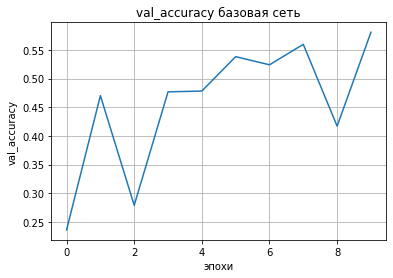

In [22]:
plt.plot(np.arange(epochs), hist.history['val_accuracy'])
plt.title('val_accuracy базовая сеть', fontsize=12)
plt.ylabel('val_accuracy')
plt.xlabel('эпохи')
plt.grid(True)
plt.show()

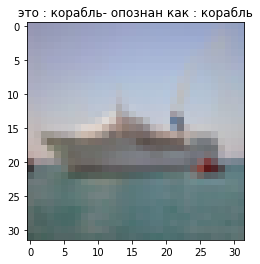

In [23]:
N = 1011
y_p=model.predict(x_test[N:N+1][:,:,:])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(x_test[N][:,:,:])
plt.title('это : '+classes[y_t[0]]+'- опознан как : '+classes[y_i[0]])
plt.show()

# Оценим рост точности при увеличении ширины сети (больше ядер)
Модель:
- количество слоёв - 3
- количество нейронов в каждом слое - 64.

In [24]:
# конфигурирование слоев нейросети
model = Sequential([
                    
    # слои нейросети отвественные за свертку и max-pooling
    Conv2D(filters=64,  # количество фильтров - эквивалентно кол-ву нейронов (ширина слоя)!!!
        kernel_size=(11, 11),  # кортеж, размер ядра фильтра (размер фильтра по осям, апертура фильтра)
        strides=(1, 1),   # шаг применения фильтра к пикселам (пропуск пикселов) - вместо пулинга
        input_shape=x_train.shape[1:],
        activation='relu',  # активация
        padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    Dropout( 0.25),

    Conv2D(filters=64,  # количество фильтров - эквивалентно кол-ву нейронов (ширина слоя)!!!
        kernel_size=(8, 8),  # кортеж размер ядра фильтра (размер фильтра по осям, апертура фильтра)
        strides=(1, 1),   # шаг применения фильтра к пикселам (пропуск пикселов) - вместо пулинга
        input_shape=x_train.shape[1:],
        activation='relu'  # активация
      ),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    Dropout( 0.25),
    
    Conv2D(filters=64, kernel_size=(5, 5), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2, 2)),
    Dropout( 0.25),

    # Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu'),
    # BatchNormalization(),
    # MaxPooling2D(pool_size=(3,3), strides=(2, 2)),
    # Dropout(0.25),
    
    # Из конволютивного слоя нельзя передать информацию в плотный слой без векторизации
    # поэтому используем layers.Flatten() чтоб не делать reshape, сглаживание CNN выхода,
    # чтобы можно было его присоединить к полносвязногому слою.

    # полносвязные слои нейронной сети
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax'),
])

# инициализация RMSprop optimizer
#opt = tensorflow.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        23296     
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 15, 15, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 64)          262208    
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 64)        

In [25]:
  print('Не используется data augmentation')
  hist = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_test, y_test),
            shuffle=True)

Не используется data augmentation
Epoch 1/10
1563/1563 [==============================] - 402s 257ms/step - loss: 1.8767 - accuracy: 0.3059 - val_loss: 1.9095 - val_accuracy: 0.3332
Epoch 2/10
1563/1563 [==============================] - 405s 259ms/step - loss: 1.5300 - accuracy: 0.4385 - val_loss: 1.9469 - val_accuracy: 0.3515
Epoch 3/10
1563/1563 [==============================] - 405s 259ms/step - loss: 1.3948 - accuracy: 0.4938 - val_loss: 1.5223 - val_accuracy: 0.4810
Epoch 4/10
1563/1563 [==============================] - 405s 259ms/step - loss: 1.3106 - accuracy: 0.5272 - val_loss: 1.5705 - val_accuracy: 0.4363
Epoch 5/10
1563/1563 [==============================] - 406s 260ms/step - loss: 1.2436 - accuracy: 0.5585 - val_loss: 1.4325 - val_accuracy: 0.4866
Epoch 6/10
1563/1563 [==============================] - 405s 259ms/step - loss: 1.1888 - accuracy: 0.5756 - val_loss: 1.3620 - val_accuracy: 0.5335
Epoch 7/10
1563/1563 [==============================] - 407s 261ms/step - loss

In [26]:
# model evaluation for training set
loss_metric_train = model.evaluate(x_train, y_train)

# проверка работы обученной модели
loss_metric_test = model.evaluate(x_test, y_test, verbose=1)

print('Test loss:', loss_metric_test[0])
print('Test accuracy:', loss_metric_test[1])

summary_data.loc["Модель увеличение ширины сети", ['layers', 'neurons', 'loss', 'accuracy', 'val_loss', 'val_accuracy']] = [ 3,  64, loss_metric_train[0], loss_metric_train[1], loss_metric_test[0], loss_metric_test[1]]
summary_data

313/313 [==============================] - 20s 63ms/step - loss: 1.4557 - accuracy: 0.5417
Test loss: 1.4557396173477173
Test accuracy: 0.541700005531311


,layers,neurons,loss,accuracy,val_loss,val_accuracy
Базовая модель,3,32,1.15717,0.58962,1.20273,0.5808
Модель увеличение ширины сети,3,64,1.3681,0.5627,1.45574,0.5417


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


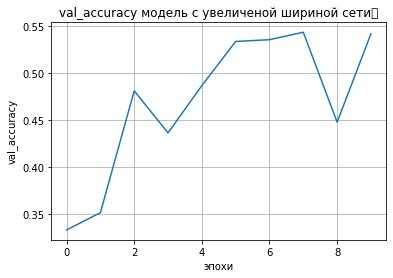

In [28]:
plt.plot(np.arange(epochs), hist.history['val_accuracy'])
plt.title('val_accuracy модель с увеличеной шириной сети	', fontsize=12)
plt.ylabel('val_accuracy')
plt.xlabel('эпохи')
plt.grid(True)
plt.show()

Лучший результат - val_accuracy = 0.5417 это хуже чем у базовой модели (0.5808),
что выглядит несколько странно. Ожидалось, что результат улучшится.

###### Вывод: 
С увеличением ширины сети точночть модели уменьшилась, т.е. с увеличением количества числа слоёв точность не всегда растёт.

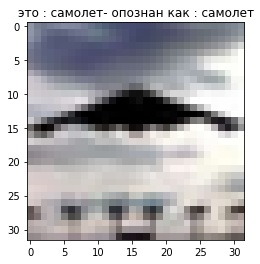

In [29]:
N = 111
y_p=model.predict(x_test[N:N+1][:,:,:])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(x_test[N][:,:,:])
plt.title('это : '+classes[y_t[0]]+'- опознан как : '+classes[y_i[0]])
plt.show()

# Оценим рост точности при увеличении глубины сети (больше слоев).
Модель:
- количество слоёв - 5
- количество нейронов в каждом слое - 32.

In [30]:
# конфигурирование слоев нейросети
model = Sequential([
                    
    # слои нейросети отвественные за свертку и max-pooling
    Conv2D(filters=32,  # количество фильтров - эквивалентно кол-ву нейронов (ширина слоя)!!!
        kernel_size=(11, 11),  # кортеж, размер ядра фильтра (размер фильтра по осям, апертура фильтра)
        strides=(1, 1),   # шаг применения фильтра к пикселам (пропуск пикселов) - вместо пулинга
        input_shape=x_train.shape[1:],
        activation='relu',  # активация
        padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    Dropout( 0.25),

    Conv2D(filters=32,  # количество фильтров - эквивалентно кол-ву нейронов (ширина слоя)!!!
        kernel_size=(8, 8),  # кортеж размер ядра фильтра (размер фильтра по осям, апертура фильтра)
        strides=(1, 1),   # шаг применения фильтра к пикселам (пропуск пикселов) - вместо пулинга
        input_shape=x_train.shape[1:],
        activation='relu'  # активация
      ),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    Dropout( 0.25),
    
    Conv2D(filters=32, kernel_size=(5, 5), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    # MaxPooling2D(pool_size=(3,3), strides=(2, 2)),
    # Dropout( 0.25),

    # Добавляем 2 слоя
    Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    # MaxPooling2D(pool_size=(3,3), strides=(2, 2)),
    # Dropout( 0.25),

    Conv2D(filters=64, kernel_size=(1, 1), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2, 2)),
    Dropout(0.25),

    # Из конволютивного слоя нельзя передать информацию в плотный слой без векторизации
    # поэтому используем layers.Flatten() чтоб не делать reshape, сглаживание CNN выхода,
    # чтобы можно было его присоединить к полносвязногому слою.

    # полносвязные слои нейронной сети
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax'),
])

# инициализация RMSprop optimizer
#opt = tensorflow.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        11648     
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 32)          65568     
                                                                 
 batch_normalization_7 (Batc  (None, 8, 8, 32)        

In [31]:
  print('Не используется data augmentation')
  hist = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_test, y_test),
            shuffle=True)

Не используется data augmentation
Epoch 1/10
1563/1563 [==============================] - 242s 154ms/step - loss: 1.9862 - accuracy: 0.2631 - val_loss: 1.9545 - val_accuracy: 0.3156
Epoch 2/10
1563/1563 [==============================] - 248s 158ms/step - loss: 1.6577 - accuracy: 0.3829 - val_loss: 1.5395 - val_accuracy: 0.4354
Epoch 3/10
1563/1563 [==============================] - 247s 158ms/step - loss: 1.5312 - accuracy: 0.4394 - val_loss: 1.6506 - val_accuracy: 0.4072
Epoch 4/10
1563/1563 [==============================] - 247s 158ms/step - loss: 1.4529 - accuracy: 0.4726 - val_loss: 1.8659 - val_accuracy: 0.3800
Epoch 5/10
1563/1563 [==============================] - 247s 158ms/step - loss: 1.3889 - accuracy: 0.4966 - val_loss: 2.3169 - val_accuracy: 0.3197
Epoch 6/10
1563/1563 [==============================] - 247s 158ms/step - loss: 1.3413 - accuracy: 0.5192 - val_loss: 1.4506 - val_accuracy: 0.4896
Epoch 7/10
1563/1563 [==============================] - 247s 158ms/step - loss

In [32]:
# model evaluation for training set
loss_metric_train = model.evaluate(x_train, y_train)

# проверка работы обученной модели
loss_metric_test = model.evaluate(x_test, y_test, verbose=1)

print('Test loss:', loss_metric_test[0])
print('Test accuracy:', loss_metric_test[1])

summary_data.loc["Модель с увеличенной глубиной сети", ['layers', 'neurons', 'loss', 'accuracy', 'val_loss', 'val_accuracy']] = [ 5,  32, loss_metric_train[0], loss_metric_train[1], loss_metric_test[0], loss_metric_test[1]]
summary_data

313/313 [==============================] - 11s 36ms/step - loss: 1.5493 - accuracy: 0.4788
Test loss: 1.5493144989013672
Test accuracy: 0.4787999987602234


,layers,neurons,loss,accuracy,val_loss,val_accuracy
Базовая модель,3,32,1.15717,0.58962,1.20273,0.5808
Модель увеличение ширины сети,3,64,1.3681,0.5627,1.45574,0.5417
Модель с увеличенной глубиной сети,5,32,1.48819,0.49062,1.54931,0.4788


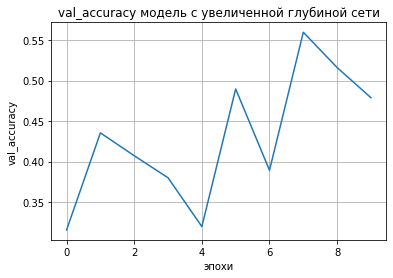

In [34]:
plt.plot(np.arange(epochs), hist.history['val_accuracy'])
plt.title('val_accuracy модель с увеличенной глубиной сети', fontsize=12)
plt.ylabel('val_accuracy')
plt.xlabel('эпохи')
plt.grid(True)
plt.show()

Лучший результат - val_accuracy = 0.4788 это хуже чем у базовой модели (0.5808)и хуже чем у модели с большой ширингой слоя (0.5417).

###### Вывод: 
С увеличением глубины сети на данном датасете точность модели ухудшилась.


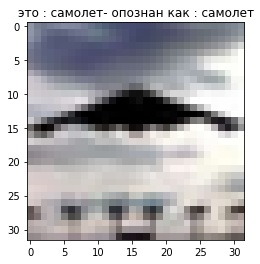

In [35]:
N = 111
y_p=model.predict(x_test[N:N+1][:,:,:])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(x_test[N][:,:,:])
plt.title('это : '+classes[y_t[0]]+'- опознан как : '+classes[y_i[0]])
plt.show()

# *(опционально) сравнить с точностью полносвязной сети для этой выборки

In [36]:
# конфигурирование слоев нейросети
model = Sequential([
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# инициализация RMSprop optimizer
#opt = tensorflow.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

# model.summary()

In [37]:
  hist = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_test, y_test),
            shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.9521 - accuracy: 0.2968 - val_loss: 1.7870 - val_accuracy: 0.3719
Epoch 2/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.7901 - accuracy: 0.3639 - val_loss: 1.7203 - val_accuracy: 0.3754
Epoch 3/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.7342 - accuracy: 0.3842 - val_loss: 1.6539 - val_accuracy: 0.4256
Epoch 4/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.6890 - accuracy: 0.4018 - val_loss: 1.6128 - val_accuracy: 0.4335
Epoch 5/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.6566 - accuracy: 0.4156 - val_loss: 1.5863 - val_accuracy: 0.4415
Epoch 6/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.6323 - accuracy: 0.4254 - val_loss: 1.5625 - val_accuracy: 0.4568
Epoch 7/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.6105 - accuracy: 0.4332 - val_loss: 1.5356 - val_ac

In [38]:
# model evaluation for training set
loss_metric_train = model.evaluate(x_train, y_train)

# проверка работы обученной модели
loss_metric_test = model.evaluate(x_test, y_test, verbose=1)

print('Test loss:', loss_metric_test[0])
print('Test accuracy:', loss_metric_test[1])

summary_data.loc["Полносвязная сеть", ['layers', 'neurons', 'loss', 'accuracy', 'val_loss', 'val_accuracy']] = [ 5,  32, loss_metric_train[0], loss_metric_train[1], loss_metric_test[0], loss_metric_test[1]]

313/313 [==============================] - 1s 4ms/step - loss: 1.5018 - accuracy: 0.4678
Test loss: 1.5018432140350342
Test accuracy: 0.46779999136924744


In [39]:
summary_data

,layers,neurons,loss,accuracy,val_loss,val_accuracy
Базовая модель,3,32,1.15717,0.58962,1.20273,0.5808
Модель увеличение ширины сети,3,64,1.3681,0.5627,1.45574,0.5417
Модель с увеличенной глубиной сети,5,32,1.48819,0.49062,1.54931,0.4788
Полносвязная сеть,5,32,1.46735,0.48672,1.50184,0.4678


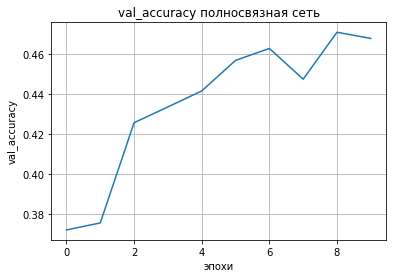

In [40]:
plt.plot(np.arange(epochs), hist.history['val_accuracy'])
plt.title('val_accuracy полносвязная сеть', fontsize=12)
plt.ylabel('val_accuracy')
plt.xlabel('эпохи')
plt.grid(True)
plt.show()

Лучший результат - val_accuracy = 0.4678 это хуже чем у остальных моделей.

__Вывод__: 
Полносвязная сеть показала результат хуже всех моделей. 

Таким оброзом наибольший эффект для данной выборки играет увеличение количества нейронов.

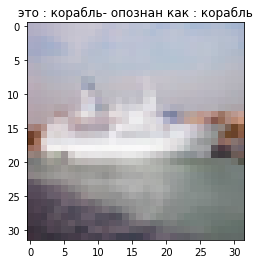

In [41]:
N = 1111
y_p=model.predict(x_test[N:N+1][:,:,:])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(x_test[N][:,:,:])
plt.title('это : '+classes[y_t[0]]+'- опознан как : '+classes[y_i[0]])
plt.show()